# ELI5 (Explain Like I'm 5) - Complete Tutorial

This comprehensive notebook combines all aspects of building, testing, and evaluating an ELI5 application using:
- **Ollama** (llama3.2:1b) for local LLM inference
- **DuckDuckGo** for free web search (no API key required)
- **LangGraph** for building the application
- **LangSmith** for tracing, debugging, and evaluation

## Table of Contents
1. [Tracing & Graph Building](#section-1)
2. [Different Run Types](#section-2)
3. [Debugging with LangGraph](#section-3)
4. [Prompt Engineering](#section-4)
5. [Experimentation & Evaluation](#section-5)

---
# Section 1: Tracing & Graph Building <a id="section-1"></a>

In this section, we'll build our ELI5 application using LangGraph and learn how to trace it with LangSmith.

## Setup Environment

Let's start by loading our environment variables from our .env file.

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
# Loads the following env variables
# LANGSMITH_TRACING=true
# LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
# LANGSMITH_PROJECT="eli5-bot"
# LANGSMITH_API_KEY="<your_key>"

# No need for OPENAI_API_KEY or TAVILY_API_KEY anymore!

True

## Initialize Tools

Let's set up DuckDuckGo search to allow our assistant to search the web when answering (free, no API key required!)

In [2]:
from langchain_community.tools import DuckDuckGoSearchRun

web_search_tool = DuckDuckGoSearchRun()

## Define Prompt Template

In [3]:
prompt = """You are a professor and expert in explaining complex topics in a way that is easy to understand. 
Your job is to answer the provided question so that even a 5 year old can understand it. 
You have provided with relevant background context to answer the question.

Question: {question} 

Context: {context}

Answer:"""
print("Prompt Template: ", prompt)

Prompt Template:  You are a professor and expert in explaining complex topics in a way that is easy to understand. 
Your job is to answer the provided question so that even a 5 year old can understand it. 
You have provided with relevant background context to answer the question.

Question: {question} 

Context: {context}

Answer:


## Build Application with Ollama

**Important:** Make sure Ollama is running with `ollama serve` before executing the cells below!

### Setup Ollama Client

In [4]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.2:1b",
    base_url="http://localhost:11434",
    temperature=0,
)

### Define State Schema

In [4]:
from typing import List
from typing_extensions import TypedDict
from langchain_core.documents import Document

class GraphState(TypedDict):
    question: str
    documents: List[str]
    messages: List[str]

### Define Graph Nodes

In [5]:
from langchain_core.messages import HumanMessage

def search(state):
    """
    Web search based on the question using DuckDuckGo.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    question = state["question"]
    documents = state.get("documents", [])

    # Web search using DuckDuckGo
    try:
        web_results = web_search_tool.invoke(question)
        web_results = Document(page_content=web_results)
        documents.append(web_results)
    except Exception as e:
        # Handle search errors gracefully
        error_doc = Document(page_content=f"Search error: {str(e)}")
        documents.append(error_doc)

    return {"documents": documents, "question": question}

    
def explain(state: GraphState):
    """
    Generate response using Ollama
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): New key added to state, messages, that contains LLM generation
    """
    question = state["question"]
    documents = state.get("documents", [])
    formatted = prompt.format(question=question, context="\n".join([d.page_content for d in documents]))
    generation = llm.invoke([HumanMessage(content=formatted)])
    return {"question": question, "messages": [generation]}

### Build & Visualize Graph

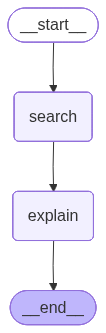

In [7]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

graph = StateGraph(GraphState)
graph.add_node("explain", explain)
graph.add_node("search", search)
graph.add_edge(START, "search")
graph.add_edge("search", "explain")
graph.add_edge("explain", END)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

## Test the Graph

In [8]:
def ask(question: str):
    for output in app.stream({"question": question}, stream_mode="updates"):
        if END in output or START in output:
            continue
        # Print any node outputs
        for key, value in output.items():
            if "messages" in value:
                print(value["messages"][0].content)

In [9]:
question = "What is complexity economics?"
ask(question)

Hello there little friend! So, you want to know about something called "complexity economics"? Well, let me tell you all about it.

You see, when we talk about money and how people make it, it's like a big puzzle. We have different pieces that fit together in certain ways, but sometimes they don't fit perfectly. That's where complexity comes in.

Imagine you're playing with blocks, and each block represents something that makes up our economy. Some blocks are easy to understand, like "people work" or "they buy things." But other blocks might be harder to grasp, like "how people learn from mistakes" or "how the government helps people."

Complexity economics is a way of thinking about how all these different pieces fit together. It's like trying to solve a big puzzle with many different parts that need to work well together.

In this case, we're talking about how countries or regions make money and grow their economies. We want to understand why some places are rich and others are poor,

## Try More Questions

In [10]:
ask("What is machine learning?")

Hello there little friend! Today, I want to tell you about something really cool called machine learning.

You know how sometimes we play games or watch videos on our phones? And the computer helps us by making decisions based on what it sees in those videos or games? Like, if a video shows a cat playing with a ball, the computer might think "oh, cats love balls!" and show you more videos like that.

Well, machine learning is kind of like that, but instead of just thinking about things, computers can learn from lots and lots of data. Data is like a big library of information, and machines can go through it and find patterns or connections between things.

Imagine you have a toy box full of different toys, and each toy has a picture on it. The computer can look at all the pictures together and say "oh, I see that most toys are red!" or "I see that most toys have wheels!"

That's basically what machine learning does. It helps computers learn from data and make predictions about new thing

In [ ]:
ask("How do airplanes fly?")

---
# Section 2: Different Run Types <a id="section-2"></a>

LangSmith supports many different types of Runs for better tracing and visualization.

## Types of Runs

LangSmith supports these run types (specify in `@traceable` decorator):

- **LLM**: Invokes an LLM
- **Retriever**: Retrieves documents from databases or other sources
- **Tool**: Executes actions with function calls
- **Chain**: Default type; combines multiple Runs into a larger process
- **Prompt**: Hydrates a prompt to be used with an LLM
- **Parser**: Extracts structured data

## LLM Runs Example

In [11]:
from langsmith import traceable

inputs = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "I'd like to book a table for two."},
]

output = {
  "choices": [
      {
          "message": {
              "role": "assistant",
              "content": "Sure, what time would you like to book the table for?"
          }
      }
  ]
}

@traceable(run_type="llm")
def chat_model(messages: list):
  return output

chat_model(inputs)

{'choices': [{'message': {'role': 'assistant',
    'content': 'Sure, what time would you like to book the table for?'}}]}

## Retriever Runs Example

In [12]:
def _convert_docs(results):
  return [
      {
          "page_content": r,
          "type": "Document",
          "metadata": {"foo": "bar"}
      }
      for r in results
  ]

@traceable(run_type="retriever")
def retrieve_langsmith_docs(query):
  # Retriever returning hardcoded dummy documents.
  contents = ["LangSmith Document 1", "LangSmith Document 2", "LangSmith Document 3"]
  return _convert_docs(contents)

retrieve_langsmith_docs("User query")

[{'page_content': 'LangSmith Document 1',
  'type': 'Document',
  'metadata': {'foo': 'bar'}},
 {'page_content': 'LangSmith Document 2',
  'type': 'Document',
  'metadata': {'foo': 'bar'}},
 {'page_content': 'LangSmith Document 3',
  'type': 'Document',
  'metadata': {'foo': 'bar'}}]

## Tool Calling Example

In [13]:
from typing import Optional

ollama_client_tools = ChatOllama(
    model="llama3.2:1b",
    base_url="http://localhost:11434",
    temperature=0
)

@traceable(run_type="tool")
def search_web(query: str):
    """Search the web for a query."""
    return f"No result found for query: {query}"

@traceable(run_type="llm")
def call_ollama(messages: List[dict], tools: Optional[List[dict]] = None) -> str:
    """Call Ollama LLM."""
    response = ollama_client_tools.invoke(messages)
    return response

@traceable(run_type="chain")
def respond(inputs, tools):
    """Main response chain."""
    response = call_ollama(inputs, tools)
    return response

tools = [{
  "type": "function",
  "function": {
    "name": "search_web",
    "description": "Search the web for a specific query",
    "parameters": {
      "type": "object",
      "properties": {"query": {"type": "string", "description": "The query to search"}},
      "required": ["query"]
    }
  }
}]

inputs = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "What is the weather in NYC?"},
]

respond(inputs, tools)

AIMessage(content="In New York City, you can expect a humid subtropical climate with cold winters and warm summers. Here's a breakdown of what you can typically expect:\n\n**Winter (December to February):**\n\n* Average high temperature: 38°F (3°C)\n* Average low temperature: 24°F (-4°C)\n* Snowfall: Moderate, with an average of 18 inches (45 cm) per year\n* Expect occasional cold snaps and frosty mornings\n\n**Spring (March to May):**\n\n* Average high temperature: 58°F (14°C)\n* Average low temperature: 43°F (6°C)\n* Spring showers are common, with an average of 4-5 inches (10-13 cm) per month\n* Expect occasional thunderstorms and pollen counts\n\n**Summer (June to August):**\n\n* Average high temperature: 84°F (29°C)\n* Average low temperature: 64°F (18°C)\n* Hot and humid, with an average of 3-4 days above 90°F (32°C) per month\n* Expect occasional heatwaves and thunderstorms\n\n**Autumn (September to November):**\n\n* Average high temperature: 73°F (23°C)\n* Average low temperatu

---
# Section 3: Debugging with LangGraph <a id="section-3"></a>

We've implemented 3 versions of our ELI5 Application using LangGraph (available in graphs.py):

1. **Working version**: Functional implementation
2. **Buggy version**: Does not explain concepts simply
3. **Flaky version**: Has unreliable search

All versions now use Ollama (llama3.2:1b) and DuckDuckGo search.

## Using LangGraph Studio

To debug and visualize these graphs, use LangGraph Studio:

```bash
langgraph dev
```

**Important:** Make sure Ollama is running with `ollama serve` before starting LangGraph dev.

This will start a local server at `http://localhost:2024` where you can:
- Visualize graph execution
- Inspect intermediate states
- Debug issues in real-time
- Compare different versions

---
# Section 4: Prompt Engineering <a id="section-4"></a>

Let's explore prompt engineering and management using LangSmith's PromptHub.

## Import LangSmith Client

In [14]:
import os
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")

## Create and Manage Prompts in PromptHub

In [15]:
from langsmith import Client
from langchain_core.prompts import ChatPromptTemplate
from langsmith.utils import LangSmithNotFoundError

client = Client(api_key=LANGSMITH_API_KEY)

# Define the prompt template
eli5_prompt_template = ChatPromptTemplate.from_messages([
    ("system", """You are an expert at explaining complex topics in simple terms that a 5-year-old could understand. 

Your task is to take a complex question and context information, then provide a clear, simple explanation using:
- Simple words and concepts
- Analogies and examples from everyday life
- Short sentences
- Engaging and friendly tone

Keep your explanation concise but complete.

Question: {question}

Context: {context}

Please explain this in simple terms that a 5-year-old would understand:
""")])

# Try to pull the prompt, if it doesn't exist, push it first
try:
    print("Trying to pull existing prompt...")
    prompt_from_hub = client.pull_prompt("eli5-concise", include_model=True)
    print("✅ Successfully pulled existing prompt from LangSmith")
except LangSmithNotFoundError:
    print("❌ Prompt not found. Creating and pushing new prompt...")
    
    # Push the prompt to LangSmith
    client.push_prompt(
        "eli5-concise",
        object=eli5_prompt_template,
        description="A prompt for explaining complex topics in simple terms"
    )
    print("✅ Successfully pushed prompt to LangSmith")
    
    # Now pull the prompt back
    prompt_from_hub = client.pull_prompt("eli5-concise", include_model=True)
    print("✅ Successfully pulled the newly created prompt")

Trying to pull existing prompt...
✅ Successfully pulled existing prompt from LangSmith


## Use PromptHub Prompt in Application

In [16]:
from langsmith import traceable

# Create Ollama client for prompting section
ollama_client_prompting = ChatOllama(
    model="llama3.2:1b",
    base_url="http://localhost:11434",
    temperature=0.7,
)

@traceable
def search_prompting(question):
    try:
        web_results = web_search_tool.invoke(question)
        return web_results
    except Exception as e:
        return f"Search error: {str(e)}"
    
@traceable
def explain_with_hub_prompt(question, context):
    # Format the prompt with the question and context
    messages = prompt_from_hub.format_messages(question=question, context=context)
    
    # Call Ollama with the formatted messages
    response = ollama_client_prompting.invoke(messages)
    
    return response.content

@traceable
def eli5_with_hub_prompt(question):
    context = search_prompting(question)
    answer = explain_with_hub_prompt(question, context)
    return answer

## Test with PromptHub Prompt

In [17]:
question = "what is complexity economics?"
print(eli5_with_hub_prompt(question))

<|start_header_id|>assistant<|end_header_id|>

Here's an explanation of Complexity Economics that a 5-year-old can understand:

Imagine you're playing with a big box of Legos. Each Lego block is like a tiny problem in the economy, and they all connect together to make something bigger.

The Economic Complexity Index (ECI) is like a special tool that helps us see how well this whole system works. It's like measuring how many blocks you have in your box!

But here's the cool thing: just because it's hard to predict what will happen next, doesn't mean we can't try. It's kind of like playing a game with Legos - sometimes things don't go as planned, but that's okay! We learn from our mistakes and make new rules.

The problem is, most people think the economy is like a big, perfect puzzle. But it's actually more like a big box of blocks that are all connected in weird ways. That's why Complexity Economics helps us understand how these connections work together to create the economy we see to

---
# Section 5: Experimentation & Evaluation <a id="section-5"></a>

Now let's run experiments and evaluate our application's performance on a dataset.

## Setup Application for Experiments

In [18]:
# Create Ollama client for experiments
ollama_client_experiment = ChatOllama(
    model="llama3.2:1b",
    base_url="http://localhost:11434",
    temperature=0.7,
)

@traceable
def search_experiment(question):
    try:
        web_results = web_search_tool.invoke(question)
        return web_results
    except Exception as e:
        return f"Search error: {str(e)}"
    
@traceable
def explain_experiment(question, context):
    formatted = prompt.format(question=question, context=context)
    
    response = ollama_client_experiment.invoke([
        {"role": "system", "content": formatted},
        {"role": "user", "content": question},
    ])
    return response.content

@traceable
def eli5_experiment(question):
    context = search_experiment(question)
    answer = explain_experiment(question, context)
    return answer

## Create/Load Dataset

In [19]:
import pandas as pd

dataset_name = "eli5-golden"

# Read the dataset CSV file
df = pd.read_csv("dataset.csv")

# Convert to LangSmith format
examples = []
for _, row in df.iterrows():
    examples.append({
        "inputs": {"question": row["input_question"]},
        "outputs": {"output": row["output_output"]}
    })

# Create dataset in LangSmith
try:
    existing_dataset = client.read_dataset(dataset_name=dataset_name)
    print(f"Dataset '{dataset_name}' already exists with {len(list(client.list_examples(dataset_name=dataset_name)))} examples")
except:
    dataset = client.create_dataset(
        dataset_name=dataset_name,
        description="ELI5 dataset for evaluating AI explanations"
    )
    
    client.create_examples(
        inputs=[ex["inputs"] for ex in examples],
        outputs=[ex["outputs"] for ex in examples],
        dataset_id=dataset.id
    )
    
    print(f"Successfully created dataset '{dataset_name}' with {len(examples)} examples")

Dataset 'eli5-golden' already exists with 9 examples


## Define Evaluators

### Custom Code Evaluator (Conciseness)

In [20]:
def conciseness(outputs: dict) -> bool:
    """Check if output is <= 200 words."""
    words = outputs["output"].split(" ")
    return len(words) <= 200

### LLM-as-a-Judge Evaluator (Correctness)

In [21]:
from pydantic import BaseModel, Field

class CorrectnessScore(BaseModel):
    """Correctness score of the answer."""
    score: int = Field(description="Score from 0 to 1")

def correctness(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    eval_prompt = """
    You are an expert data labeler evaluating model outputs for correctness.

    <Rubric>
        A correct answer:
        - Provides accurate information
        - Uses suitable analogies and examples
        - Contains no factual errors
        - Is logically consistent
    </Rubric>

    <input>{}</input>
    <output>{}</output>
    <reference_outputs>{}</reference_outputs>
    """.format(inputs["question"], outputs["output"], reference_outputs["output"])
    
    structured_llm = ChatOllama(
        model="llama3.2:1b", # You can use a relatively large model like llama3.2:3b as evaluator here
        base_url="http://localhost:11434",
        temperature=0
    ).with_structured_output(CorrectnessScore)
    
    generation = structured_llm.invoke([HumanMessage(content=eval_prompt)])
    return generation.score == 1

## Define Run Function

In [22]:
def run(inputs: dict):
    """Run the application and return output in expected format."""
    try:
        result = eli5_experiment(inputs["question"])
        return {"output": result if result else ""}
    except Exception as e:
        print(f"Error in run: {e}")
        return {"output": f"Error: {str(e)}"}

## Run Experiment

**Note:** This may take a while depending on your hardware and the number of examples in the dataset.

In [23]:
from langsmith import evaluate

results = evaluate(
    run,
    data=dataset_name,
    evaluators=[correctness, conciseness],
    experiment_prefix="eli5-ollama-llama3.2-1b"
)

print("\n" + "="*50)
print("Experiment Complete!")
print("="*50)
print(f"Results: {results}")

View the evaluation results for experiment: 'eli5-ollama-llama3.2-1b-d3dda18f' at:
https://smith.langchain.com/o/4f5768b4-9e19-4abd-8067-61a12e1df8a4/datasets/cb04c0da-21f5-4d9b-969e-3d327d9e23c2/compare?selectedSessions=a2195c8c-ebec-4f03-ab1a-45a1ba154ab6




0it [00:00, ?it/s]


Experiment Complete!
Results: <ExperimentResults eli5-ollama-llama3.2-1b-d3dda18f>


---
# Summary

In this comprehensive notebook, we covered:

1. **Tracing & Graph Building**: Built an ELI5 application with LangGraph and Ollama
2. **Different Run Types**: Learned about LLM, Retriever, Tool, and Chain run types
3. **Debugging**: Explored how to use LangGraph Studio for debugging
4. **Prompt Engineering**: Managed prompts using LangSmith's PromptHub
5. **Experimentation**: Evaluated our application using custom evaluators and LLM-as-a-judge

## Key Takeaways

- **Local Development**: Using Ollama (llama3.2:1b) allows for free, local LLM inference
- **Free Search**: DuckDuckGo provides free web search without requiring an API key
- **LangSmith Integration**: Tracing, debugging, and evaluation are seamlessly integrated
- **Production Ready**: This pattern can be scaled to production with larger models and better infrastructure

## Next Steps

1. Experiment with larger Ollama models (llama3.2:3b, llama3.1:8b) for better quality
2. Customize prompts in PromptHub for your specific use case
3. Add more evaluators to measure different aspects of quality
4. Deploy the application using LangGraph Cloud for production use